In [1]:
import pandas as pd

MAX_PRICE = 100000


In [2]:
products = pd.read_json("data/products.jsonl", lines=True)
print(products.shape[0])
products.loc[products["price"] < 0, "price"] *= -1
products = products[products["price"] < MAX_PRICE]
products["category_path"] = products["category_path"].str.rsplit(';', n=1, expand=True)[1]
products.rename(columns={"category_path": "category"}, inplace=True)
products.to_json("data/products_clean.jsonl", orient='records', lines=True)
print(products.shape[0])


319
308


In [3]:
    sessions = pd.read_json("data/sessions.jsonl", lines=True)
    products = pd.read_json("data/products_clean.jsonl", lines=True)
    print(sessions.shape[0])
    sessions = sessions[sessions["product_id"].isin(products["product_id"])]
    sessions = sessions.fillna({"user_id": sessions.groupby("session_id")["user_id"].transform('median')})
    sessions = sessions.dropna(subset=["user_id"])
    print(sessions.shape[0])
    sessions = sessions.astype({'user_id': 'int32', 'product_id': 'int32', 'purchase_id': "Int64"}, errors='ignore')
    sessions.to_json("data/sessions_clean.jsonl", orient='records', lines=True)

56883
53278


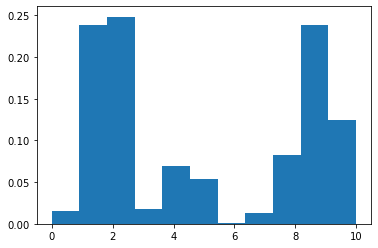

In [4]:
bought = sessions[sessions["event_type"] == "BUY_PRODUCT"]
views = sessions[sessions["event_type"] == "VIEW_PRODUCT"]
successful_sessions = sessions[sessions["session_id"].isin(bought["session_id"])]
unsuccessful_sessions = sessions[~sessions["session_id"].isin(bought["session_id"])]
successful_views_count = successful_sessions.groupby("session_id")["user_id"].agg('count') - 1
unsuccessful_views_count = unsuccessful_sessions.groupby("session_id")["user_id"].agg('count')
import matplotlib.pyplot as plt
plt.figure()
_ = plt.hist(successful_views_count.values, density=True, bins=11)
plt.show()


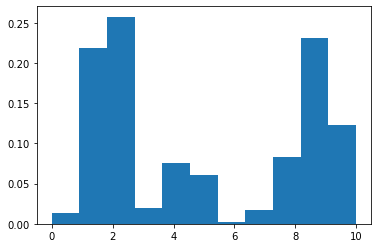

1183
2937
wyglądają podobnie niestety
[10  1 10 ... 10  0  1]
2937
1183


In [9]:
bought_with_discount = bought[bought["offered_discount"] != 0]
successful_sessions_with_discount = sessions[sessions["session_id"].isin(bought_with_discount["session_id"])]
successful_views_count_with_discount = successful_sessions_with_discount.groupby("session_id")["user_id"].agg('count') - 1
plt.figure()
_ = plt.hist(successful_views_count_with_discount.values, density=True, bins=11)
plt.show()
print(bought_with_discount.shape[0])
print(bought.shape[0])
print("wyglądają podobnie niestety")
print(successful_views_count_with_discount.values)
print(len(successful_views_count.values))
print(len(successful_views_count_with_discount.values))


In [21]:
import numpy as np
from collections import Counter

percentage_undecided_with_discount = sum(map(lambda x : x > 5, successful_views_count_with_discount.values)) / len(successful_views_count_with_discount.values)
percentage_undecided_without_discount = sum(map(lambda x : x > 5, successful_views_count.values)) / len(successful_views_count.values)
print(percentage_undecided_without_discount)
print(percentage_undecided_with_discount)
print("no kurde nie dziala ta znizka")

[(0, 14), (1, 235), (2, 277), (3, 21), (4, 81), (5, 65), (6, 2), (7, 18), (8, 89), (9, 249), (10, 132)]
0.4160708205652026
0.41420118343195267
no kurde nie dziala ta znizka


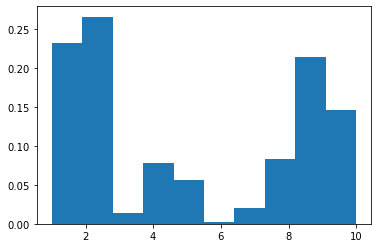

2826
7166
2826


In [17]:
unsuccessful_sessions_with_discount = unsuccessful_sessions[unsuccessful_sessions["offered_discount"] != 0]
unsuccessful_views_count_with_discount = unsuccessful_sessions_with_discount.groupby("session_id")["user_id"].agg('count')
plt.figure()
_ = plt.hist(unsuccessful_views_count_with_discount.values, density=True, bins=10)
plt.show()
print(unsuccessful_views_count_with_discount.shape[0])
print(len(unsuccessful_views_count.values))
print(len(unsuccessful_views_count_with_discount.values))


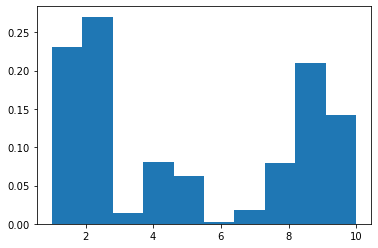

7166


In [18]:
import matplotlib.pyplot as plt
plt.figure()
_ = plt.hist(unsuccessful_views_count.values, density=True, bins=10)
plt.show()
print(unsuccessful_views_count.shape[0])




In [23]:
percentage_undecided_with_discount = sum(map(lambda x : x > 5, unsuccessful_views_count_with_discount.values)) / len(unsuccessful_views_count_with_discount.values)
percentage_undecided_without_discount = sum(map(lambda x : x > 5, unsuccessful_views_count.values)) / len(unsuccessful_views_count.values)
print(percentage_undecided_without_discount)
print(percentage_undecided_with_discount)
print(sorted(Counter(successful_views_count_with_discount.values).items()))
print(sorted(Counter(successful_views_count.values).items()))
print(sorted(Counter(unsuccessful_views_count_with_discount.values).items()))
print(sorted(Counter(unsuccessful_views_count.values).items()))

0.4072006698297516
0.4179051663128096
[(0, 14), (1, 235), (2, 277), (3, 21), (4, 81), (5, 65), (6, 2), (7, 18), (8, 89), (9, 249), (10, 132)]
[(0, 41), (1, 636), (2, 663), (3, 47), (4, 186), (5, 142), (6, 3), (7, 34), (8, 219), (9, 635), (10, 331)]
[(1, 591), (2, 676), (3, 34), (4, 200), (5, 144), (6, 5), (7, 50), (8, 212), (9, 544), (10, 370)]
[(1, 1488), (2, 1744), (3, 89), (4, 523), (5, 404), (6, 12), (7, 118), (8, 514), (9, 1354), (10, 920)]


In [25]:
print("no mają takie same rozkłady niezależnie od zniżki i tego czy będzie zakup czy nie")


sessions_with_discount = sessions[sessions["offered_discount"] != 0]
sessions_without_discount = sessions[sessions["offered_discount"] == 0]

successfull_sessions_without_discount = sessions_without_discount[sessions_without_discount["session_id"].isin(bought["session_id"])]

successful_views_count_without_discount = successfull_sessions_without_discount.groupby("session_id")["user_id"].agg('count') - 1
sessions_with_discount_views_count = sessions_with_discount.groupby("session_id")["user_id"].agg('count') - 1
sessions_without_discount_views_count = sessions_without_discount.groupby("session_id")["user_id"].agg('count') - 1

percentage_successful_with_discount = len(successful_views_count_with_discount.values) / len(sessions_with_discount_views_count.values)
percentage_successful_without_discount = len(successful_views_count_without_discount.values) / len(sessions_without_discount_views_count.values)
print(percentage_successful_with_discount)
print(percentage_successful_without_discount)
print("troche dziala")



no mają takie same rozkłady niezależnie od zniżki i tego czy będzie zakup czy nie
0.2950860563731604
0.2878240892681326
no kurde nie dziala ta znizka
